# Config

In [1]:
import os

In [2]:
##### file system
INPUT_DIR = "/kaggle/input/audio-mnist/data"
WORKING_DIR = "/kaggle/working"

##### dataset
SAMPLE_RATE = 48_000
MAX_INPUT_SIZE = 65_536

##### training
TRAIN_PERCENTAGE = 0.8
BATCH_SIZE = 64
DATA_PERCENTAGE = 0.5

In [3]:
if not os.path.exists(WORKING_DIR):
    os.mkdir(WORKING_DIR)

# Explore Data

In [4]:
from tqdm import tqdm
from scipy.io import wavfile
import shutil
import matplotlib.pyplot as plt
import pandas as pd

## Prepare Data for PyTorch

I will be using PyTorch, to load a custom dataset it needs some fixing.

- I will create a csv file with information regarding all files

In [5]:
def create_csv_info():
    # initialize the dataset
    dataset = pd.DataFrame(columns=["file", "label", "speaker"])

    for speaker in tqdm(os.listdir(INPUT_DIR)):
        # check if "speaker" is a folder
        # "speaker" should be a folder with all the recordings from the given
        #   speaker, the name of the speaker is the name of the folder
        if not os.path.isdir(os.path.join(INPUT_DIR, speaker)):
            continue

        for file in os.listdir(os.path.join(INPUT_DIR, speaker)):
            label = file.split("_")[0]
            file_path = os.path.join(speaker, file)

            dataset = dataset.append({
                "file": file_path,
                "label": label,
                "speaker": speaker
            }, ignore_index=True)

    # write dataset as csv
    dataset.to_csv(os.path.join(WORKING_DIR, "dataset.csv"), index=False)

In [6]:
create_csv_info()

100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


# Load Dataset

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np


In [8]:
class AudioSample():
    # this defines one audio sample
    def __init__(self, sample_rate, samples):
        self.sample_rate = sample_rate
        self.samples = samples

    def display(self):
        plt.plot(self.samples)
        plt.show()


class AudioDescription():
    # apart from the audio also has the label and the speaker
    def __init__(self, audio_sample, label, speaker):
        self.audio_sample = audio_sample
        self.label = label
        self.speaker = speaker

    def display(self):
        self.audio_sample.display()
        print("Label: ", self.label)
        print("Speaker: ", self.speaker)


class AudioMNIST(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        csv_file_full_path = os.path.join(root_dir, csv_file)

        self.dataset = pd.read_csv(csv_file_full_path)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_path = os.path.join(self.root_dir, self.dataset.iloc[idx, 0])

        sample_rate, samples = wavfile.read(file_path)

        audio_description = AudioDescription(
            AudioSample(sample_rate, samples),
            self.dataset.iloc[idx, 1],
            self.dataset.iloc[idx, 2]
        )

        if self.transform:
            audio_description = self.transform(audio_description)

        return audio_description


## Transforms

The data in dataset does not have all the same size. So transformations are
required. Two transformations are possible. Padding and Cropping.

In [9]:
class Padding():
    def __init__(self, output_size=MAX_INPUT_SIZE, mode="edge"):
        # output size is an integer
        # for mode check np.pad https://numpy.org/doc/stable/reference/generated/numpy.pad.html
        self.output_size = output_size
        self.mode = mode

    def __call__(self, audio_description):
        # sample is an AudioDescription
        if len(audio_description.audio_sample.samples) > self.output_size:
            # throw error; cannot pad sample to a smaller size
            raise ValueError("Cannot pad sample to a smaller size")

        new_samples = np.pad(audio_description.audio_sample.samples, ((self.output_size - len(audio_description.audio_sample.samples) + 1) //
                                                                      2, (self.output_size - len(audio_description.audio_sample.samples)) // 2), mode=self.mode)

        return AudioDescription(
            AudioSample(audio_description.audio_sample.sample_rate, new_samples),
            audio_description.label,
            audio_description.speaker
        )


class RandomCrop():
    def __init__(self, output_size=int(MAX_INPUT_SIZE/2)):
        # output size is an integer
        self.output_size = output_size

    def __call__(self, audio_description):
        # audio_sample is an AudioDescription
        if len(audio_description.audio_sample.samples) <= self.output_size:
            # pad the sample
            audio_description = Padding(self.output_size)(audio_description)
        else:
            # get random start index
            start_index = np.random.randint(
                0, len(audio_description.audio_sample.samples) - self.output_size)

            audio_description = AudioDescription(AudioSample(
                audio_description.audio_sample.sample_rate, audio_description.audio_sample.samples[start_index:start_index + self.output_size]),
                audio_description.label,
                audio_description.speaker
            )

        return audio_description


## Putting it all together

In [10]:
dataset = AudioMNIST(WORKING_DIR + "/dataset.csv",
                     INPUT_DIR, transform=RandomCrop())

# split dataset into train and test
train_size = int(TRAIN_PERCENTAGE * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size])


def my_collate(batch):
    # batch is a list of AudioDescription
    samples = []
    labels = []
    speakers = []

    for audio_description in batch:
        samples.append(audio_description.audio_sample.samples)
        labels.append(audio_description.label)
        speakers.append(audio_description.speaker)

    # convert the list of audio samples to a tensor with shape [N, W]
    X = torch.tensor(samples)

    # add a new dimension to the tensor to get the desired shape [N, 1, W]
    X = X.unsqueeze(1)

    # convert the lists of labels and speakers to tensors
    y = torch.tensor(labels)
    z = torch.tensor(speakers)

    # return the modified tensors
    return X, y, z


dataloader_train = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=my_collate)
dataloader_test = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=my_collate)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
# show one sample with the loader
for sample, label, speaker in dataloader_train:
    print(f"Shape of X [N, C, W]: {sample.shape}")
    print(f"Shape of y: {label.shape} {label.dtype}")
    break
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

Shape of X [N, C, W]: torch.Size([64, 1, 32768])
Shape of y: torch.Size([64]) torch.int64


# Model

In [12]:
from torch import nn
import random
import time

In [13]:
# get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
class AutoEncoder(nn.Module):
    def __init__(self, convolutional_layers=2):
        super().__init__()

        if convolutional_layers < 1:
            raise ValueError("Convolutional layers must be at least 1")

        self.convolutional_layers = convolutional_layers

        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()

    def forward(self, x):
        x = x.float()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def _build_encoder(self):
        layers = []

        layers.append(nn.Conv1d(1, 32, kernel_size=9, stride=1, padding=4))
        layers.append(nn.BatchNorm1d(32))
        layers.append(nn.Tanh())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))

        for i in range(self.convolutional_layers - 1):
            # add a convolutional layer with 2^i filters, kernel size 9, stride 1, padding 'same'
            layers.append(nn.Conv1d(2**i*32, 2**(i+1)*32,
                          kernel_size=9, stride=1, padding=4))

            layers.append(nn.BatchNorm1d(2**(i+1)*32))
            # add a tanh activation function
            layers.append(nn.Tanh())

            # add a max pooling layer with kernel size 2 and stride 2
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))

        return nn.Sequential(*layers)

    def _build_decoder(self):
        layers = []

        # i decreasing from convolutional_layers to 0
        for i in range(self.convolutional_layers - 2, -1, -1):
            layers.append(nn.Upsample(scale_factor=2))
            layers.append(nn.ConvTranspose1d(2**(i+1)*32, 2**i *
                          32, kernel_size=9, stride=1, padding=4))
            layers.append(nn.BatchNorm1d(2**i*32))
            layers.append(nn.Tanh())

        layers.append(nn.Upsample(scale_factor=2))
        layers.append(nn.ConvTranspose1d(
            32, 1, kernel_size=9, stride=1, padding=4))
        layers.append(nn.BatchNorm1d(1))
        layers.append(nn.Tanh())

        return nn.Sequential(*layers)


# Training

In [15]:
def train(data_loader, model, loss_fn, optimizer):
    model.train()

    for batch, (sample, label, _) in enumerate(data_loader):
        # normalize the audio wav sample
        sample = sample / 32768

        sample, label = sample.to(device), label.to(device)

        sample = sample.float()

        # compute prediction error
        pred = model(sample)
        loss = loss_fn(pred, sample)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(sample)
            print(
                f"loss: {loss:>7f}  [{current:>5d}/{len(data_loader.dataset):>5d}]")

        del sample, label


def test(data_loader, model, loss_fn, name):
    model.eval()

    test_loss, average_mse = 0, 0
    showed = False

    with torch.no_grad():
        for sample, label, _ in data_loader:
            # normalize the audio wav sample
            # passing to the realm of values between -1 and 1
            # or wav format 32-bit floating-point
            # check https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html
            sample = sample / 32768

            sample, label = sample.to(device), label.to(device)

            sample.float()

            pred = model(sample)
            test_loss += loss_fn(pred, sample).item()

            average_mse += torch.mean((pred - sample) ** 2)

            # show a random wave
            if not showed:
                showed = True
                sample = sample.cpu().detach().numpy()
                pred = pred.cpu().detach().numpy()

                # Create the first plot
                plt.figure()
                plt.plot(sample[0][0])
                plt.title('Original Sample')
                plt.legend(['Original'])
                plt.show()

                # Create the second plot
                plt.figure()
                plt.plot(pred[0][0])
                plt.title('Reconstructed Sample')
                plt.legend(['Reconstructed'])
                plt.show()
                
                # save the sound
                wavfile.write("test_sample_" + str(name) + ".wav", SAMPLE_RATE, sample[0][0])
                wavfile.write("test_pred_" + str(name) + ".wav", SAMPLE_RATE, pred[0][0])

    test_loss /= len(data_loader)
    average_mse /= len(data_loader)

    print(
        f"Test Error: \n Avg loss: {test_loss:>8f} \n Avg MSE: {average_mse:>8f} \n")
    
    return test_loss, average_mse


In [17]:
del model

NameError: name 'model' is not defined

Training with 4 convolutional layers
Epoch 0:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.442341  [    0/24000]
loss: 0.034378  [ 6400/24000]
loss: 0.022725  [12800/24000]
loss: 0.027791  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

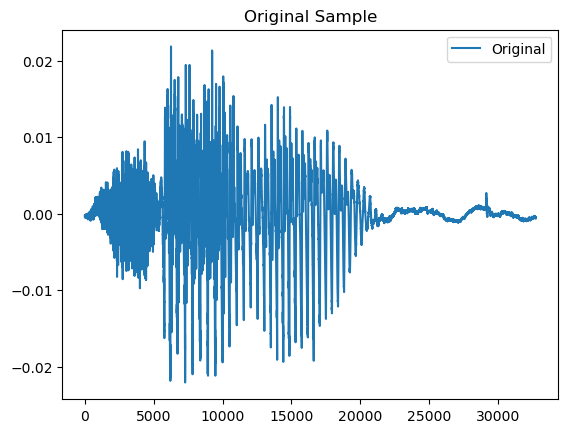

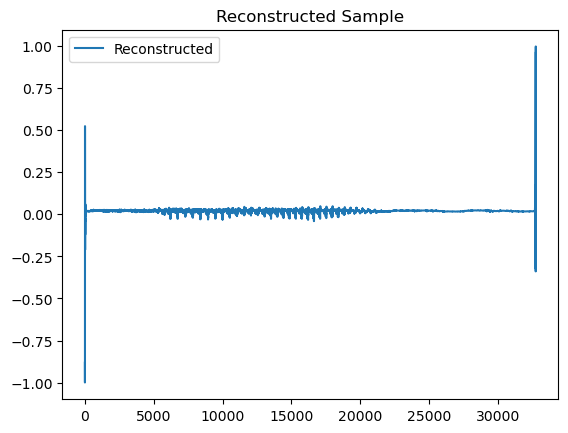

Test Error: 
 Avg loss: 0.000764 
 Avg MSE: 0.000764 

Epoch 1:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.009691  [    0/24000]
loss: 0.007158  [ 6400/24000]
loss: 0.009297  [12800/24000]
loss: 0.019800  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

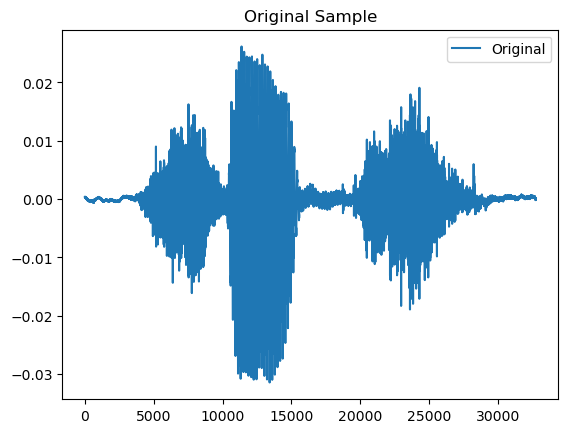

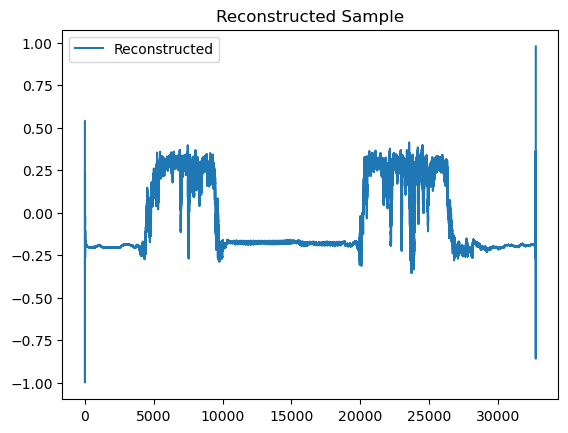

Test Error: 
 Avg loss: 0.034746 
 Avg MSE: 0.034746 

Epoch 2:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.005629  [    0/24000]
loss: 0.005383  [ 6400/24000]
loss: 0.005111  [12800/24000]
loss: 0.005872  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

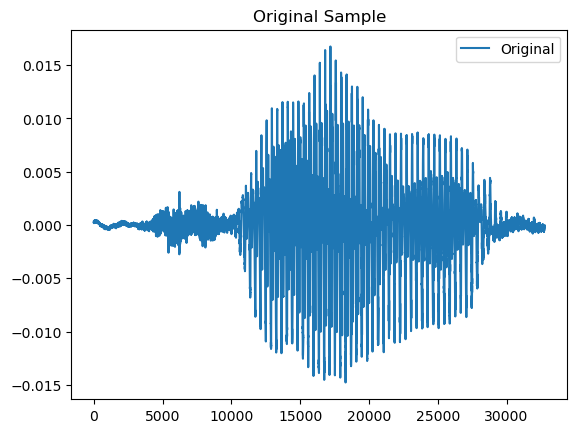

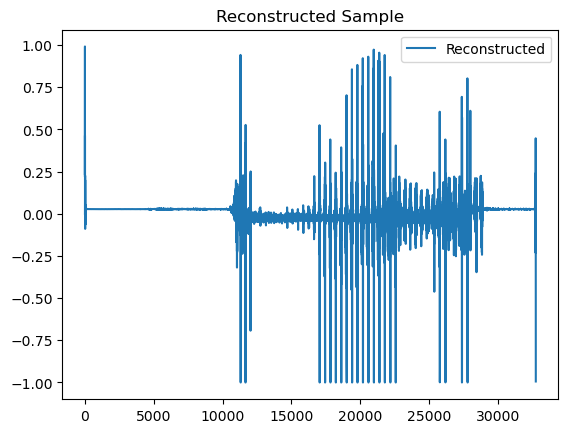

Test Error: 
 Avg loss: 0.007393 
 Avg MSE: 0.007393 

Epoch 3:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.002348  [    0/24000]
loss: 0.005426  [ 6400/24000]
loss: 0.002011  [12800/24000]
loss: 0.002886  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

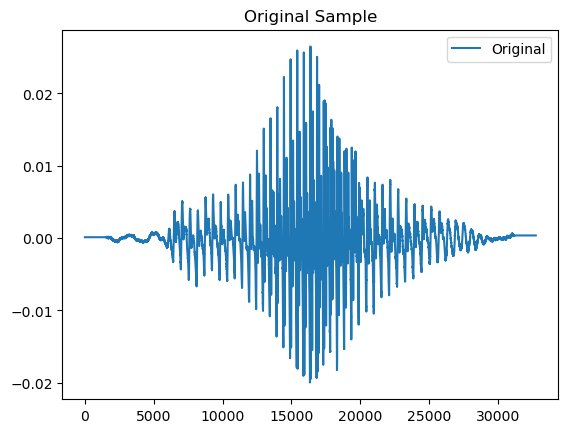

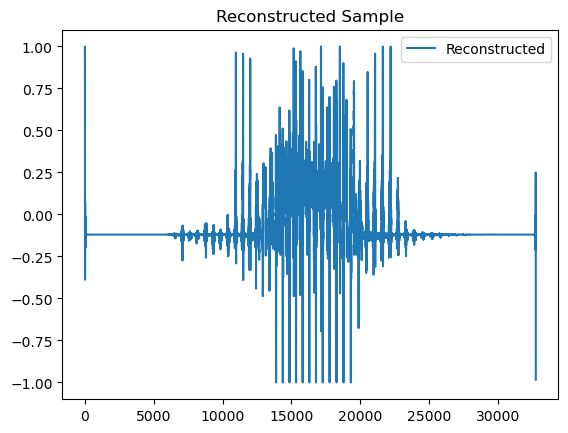

Test Error: 
 Avg loss: 0.021615 
 Avg MSE: 0.021615 

Epoch 4:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.003310  [    0/24000]
loss: 0.002091  [ 6400/24000]
loss: 0.003985  [12800/24000]
loss: 0.001947  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

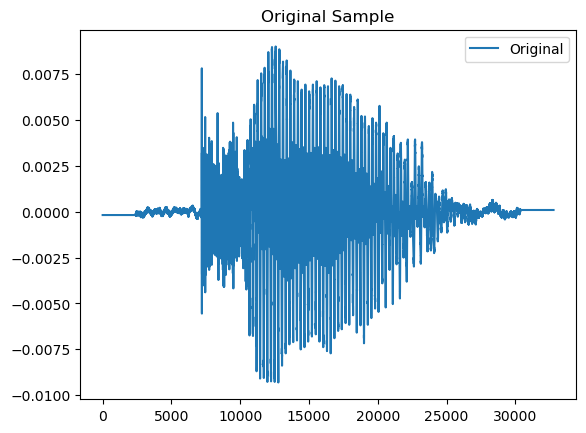

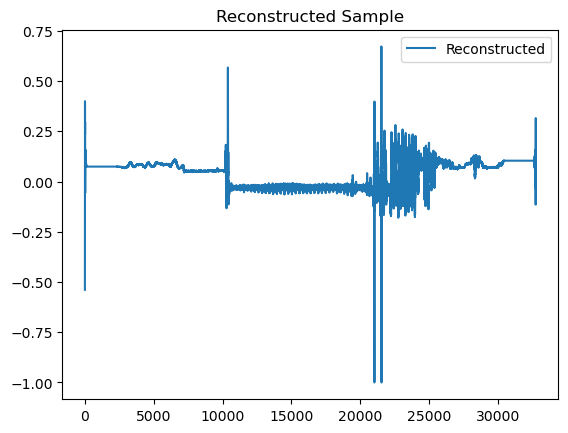

Test Error: 
 Avg loss: 0.005281 
 Avg MSE: 0.005281 

Epoch 5:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.001995  [    0/24000]
loss: 0.000987  [ 6400/24000]
loss: 0.001454  [12800/24000]
loss: 0.002326  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

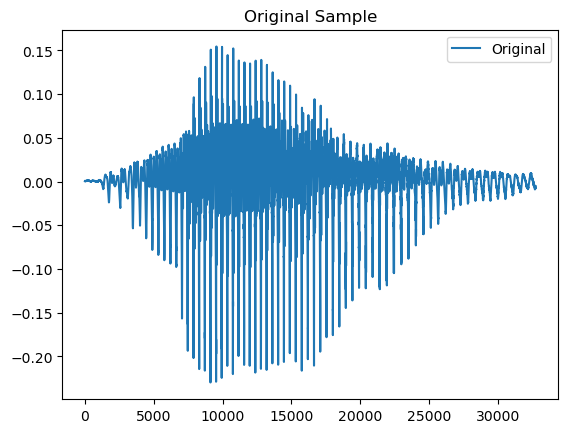

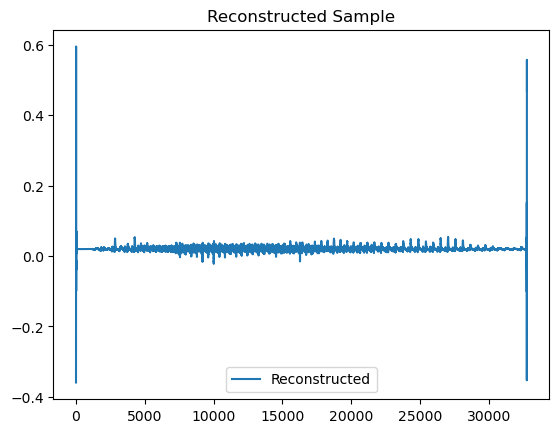

Test Error: 
 Avg loss: 0.000510 
 Avg MSE: 0.000510 

Epoch 6:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.001244  [    0/24000]
loss: 0.001117  [ 6400/24000]
loss: 0.000807  [12800/24000]
loss: 0.000794  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

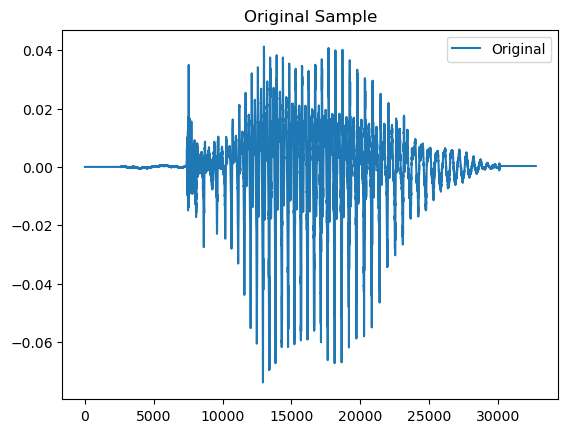

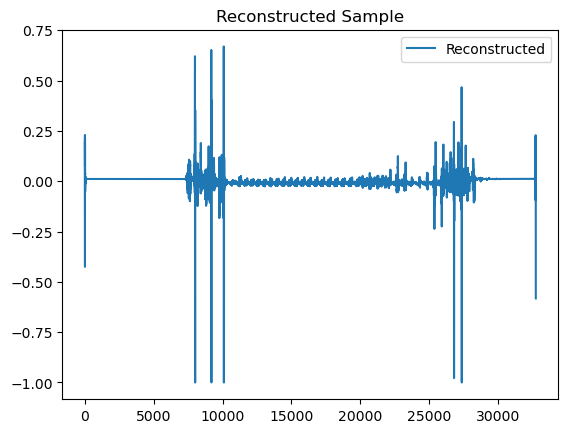

Test Error: 
 Avg loss: 0.004372 
 Avg MSE: 0.004372 

Epoch 7:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000695  [    0/24000]
loss: 0.000580  [ 6400/24000]
loss: 0.000595  [12800/24000]
loss: 0.000365  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

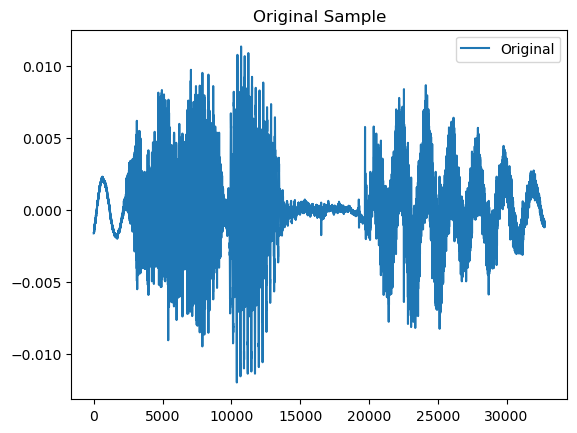

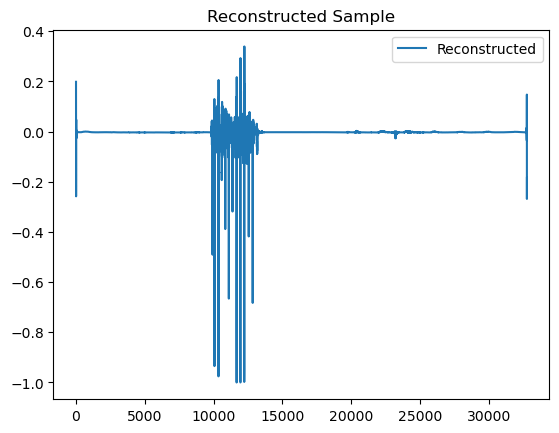

Test Error: 
 Avg loss: 0.005010 
 Avg MSE: 0.005010 

Epoch 8:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000497  [    0/24000]
loss: 0.000239  [ 6400/24000]
loss: 0.000160  [12800/24000]
loss: 0.000071  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

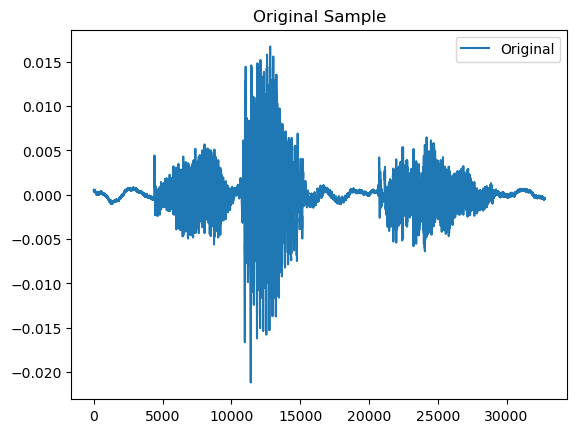

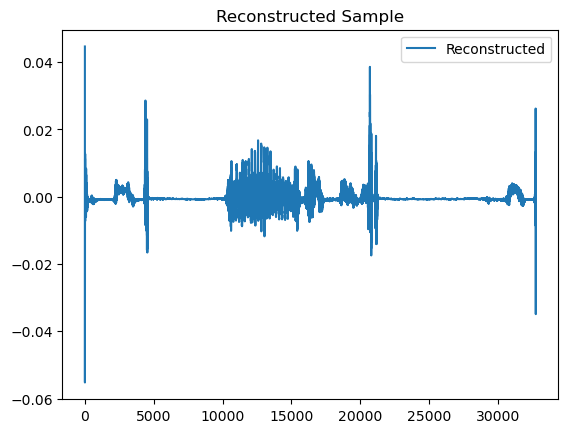

Test Error: 
 Avg loss: 0.000038 
 Avg MSE: 0.000038 

Epoch 9:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000084  [    0/24000]
loss: 0.000010  [ 6400/24000]
loss: 0.000006  [12800/24000]
loss: 0.000019  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

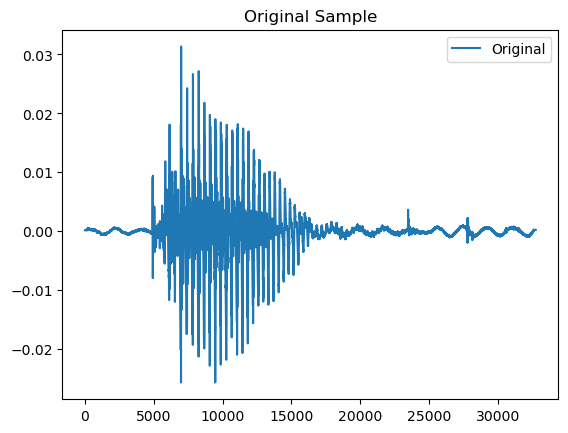

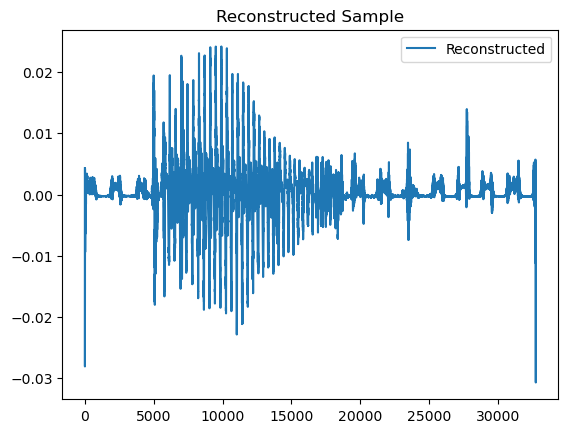

Test Error: 
 Avg loss: 0.000012 
 Avg MSE: 0.000012 

Epoch 10:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000019  [    0/24000]
loss: 0.000005  [ 6400/24000]
loss: 0.000009  [12800/24000]
loss: 0.000010  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

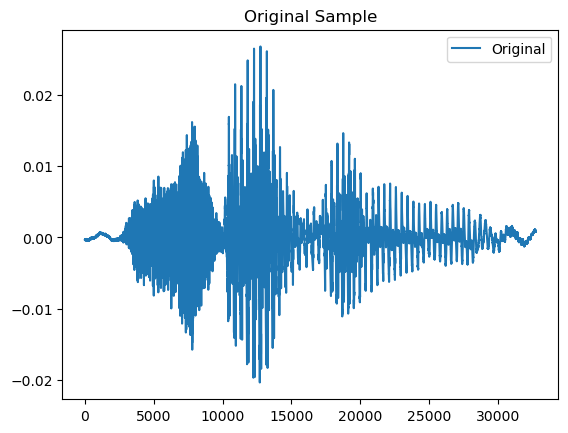

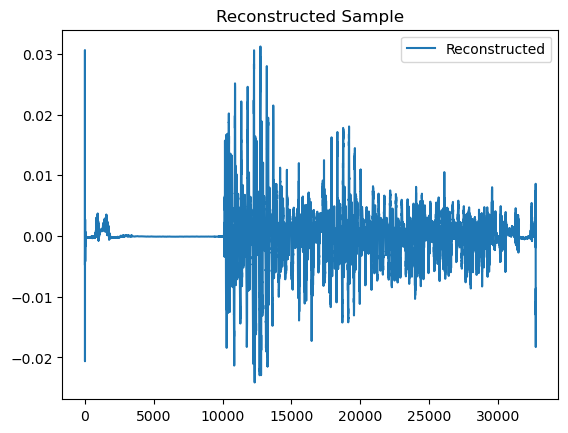

Test Error: 
 Avg loss: 0.000009 
 Avg MSE: 0.000009 

Epoch 11:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000010  [    0/24000]
loss: 0.000006  [ 6400/24000]
loss: 0.000014  [12800/24000]
loss: 0.000010  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

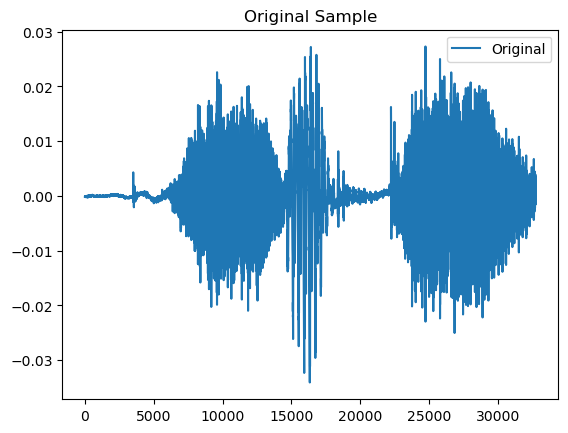

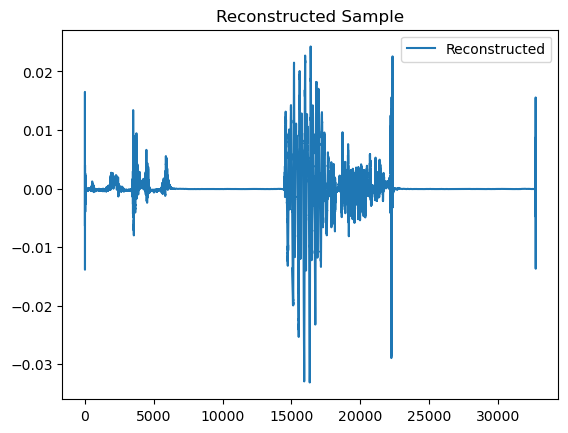

Test Error: 
 Avg loss: 0.000008 
 Avg MSE: 0.000008 

Epoch 12:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000004  [    0/24000]
loss: 0.000004  [ 6400/24000]
loss: 0.000015  [12800/24000]
loss: 0.000005  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

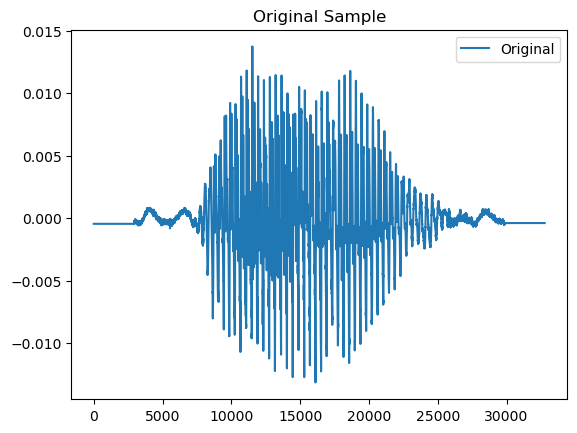

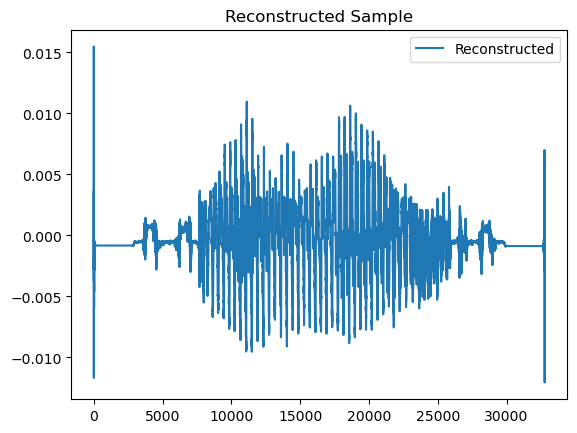

Test Error: 
 Avg loss: 0.000008 
 Avg MSE: 0.000008 

Epoch 13:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000004  [    0/24000]
loss: 0.000006  [ 6400/24000]
loss: 0.000003  [12800/24000]
loss: 0.000003  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

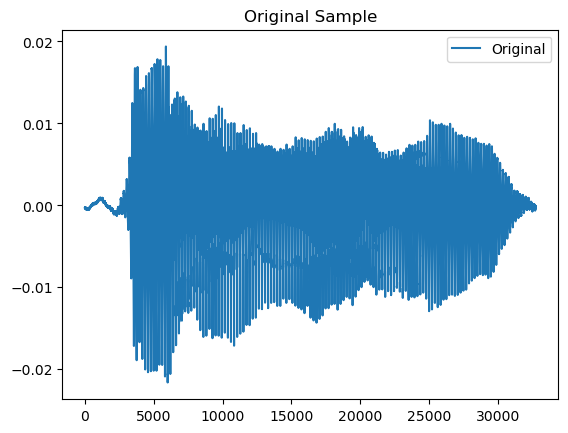

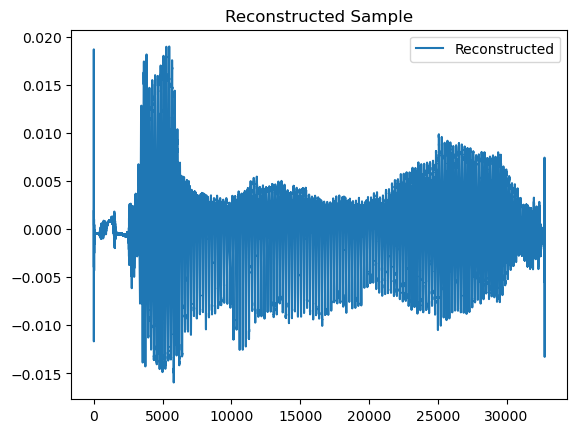

Test Error: 
 Avg loss: 0.000006 
 Avg MSE: 0.000006 

Epoch 14:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000004  [    0/24000]
loss: 0.000008  [ 6400/24000]
loss: 0.000004  [12800/24000]
loss: 0.000019  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

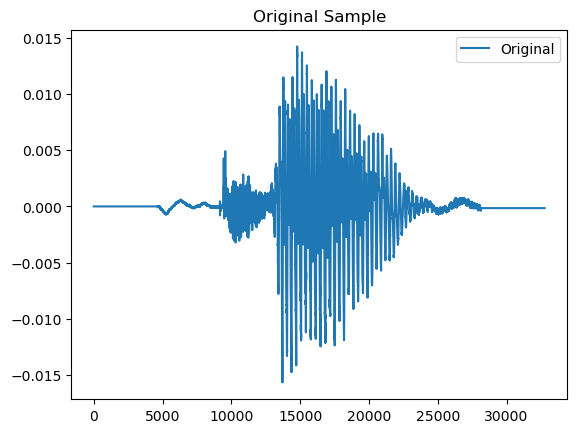

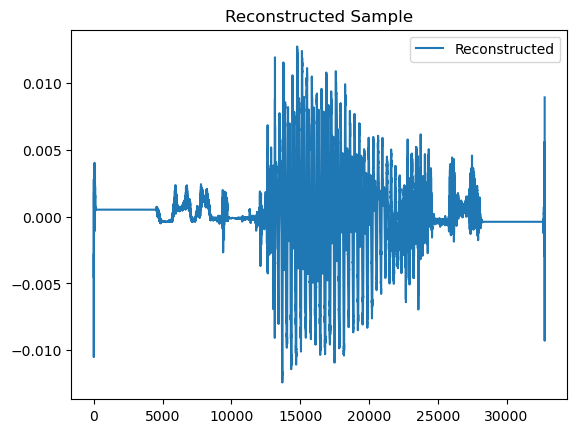

Test Error: 
 Avg loss: 0.000005 
 Avg MSE: 0.000005 

Epoch 15:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000004  [    0/24000]
loss: 0.000013  [ 6400/24000]
loss: 0.000004  [12800/24000]
loss: 0.000005  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

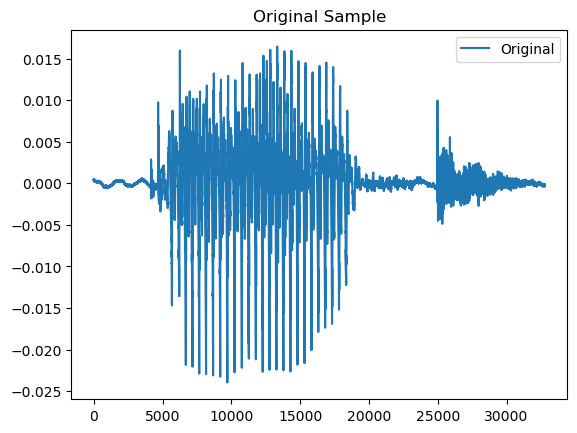

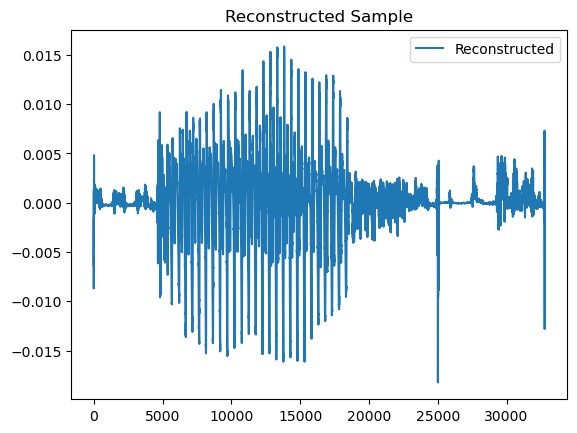

Test Error: 
 Avg loss: 0.000005 
 Avg MSE: 0.000005 

Epoch 16:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000005  [    0/24000]
loss: 0.000006  [ 6400/24000]
loss: 0.000002  [12800/24000]
loss: 0.000003  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

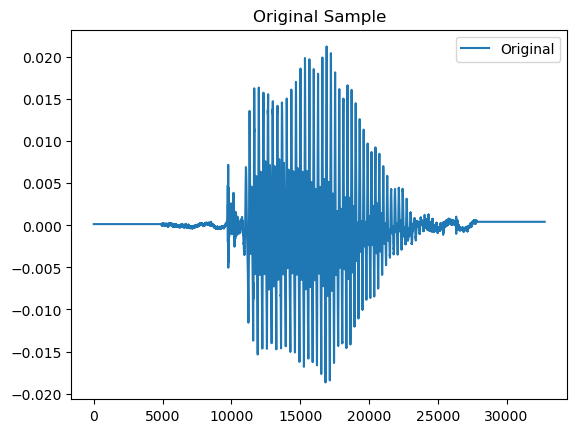

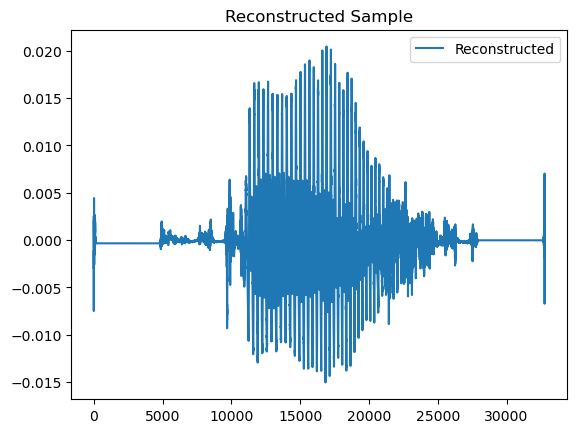

Test Error: 
 Avg loss: 0.000004 
 Avg MSE: 0.000004 

Epoch 17:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000008  [    0/24000]
loss: 0.000007  [ 6400/24000]
loss: 0.000010  [12800/24000]
loss: 0.000003  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

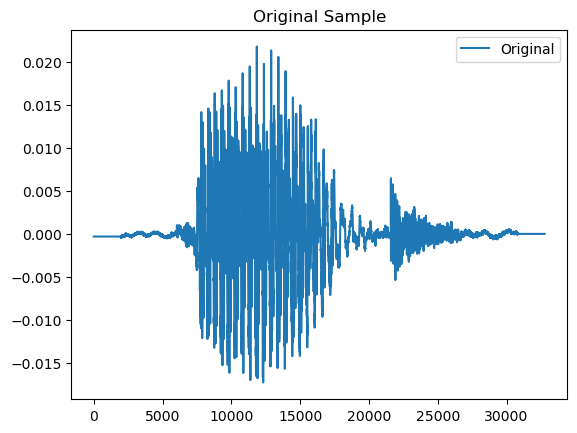

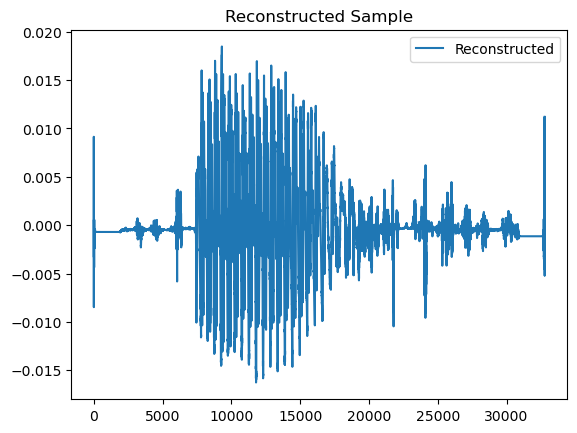

Test Error: 
 Avg loss: 0.000004 
 Avg MSE: 0.000004 

Epoch 18:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000003  [    0/24000]
loss: 0.000007  [ 6400/24000]
loss: 0.000005  [12800/24000]
loss: 0.000005  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

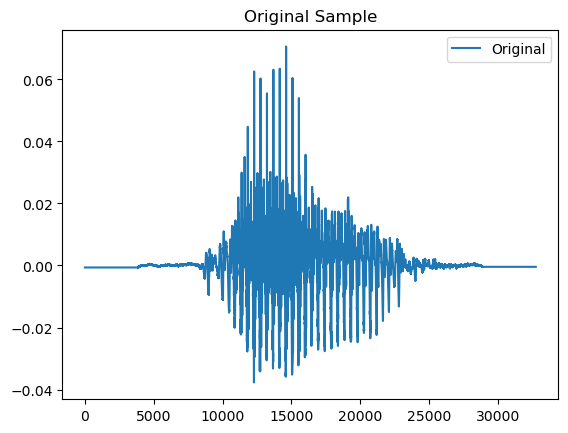

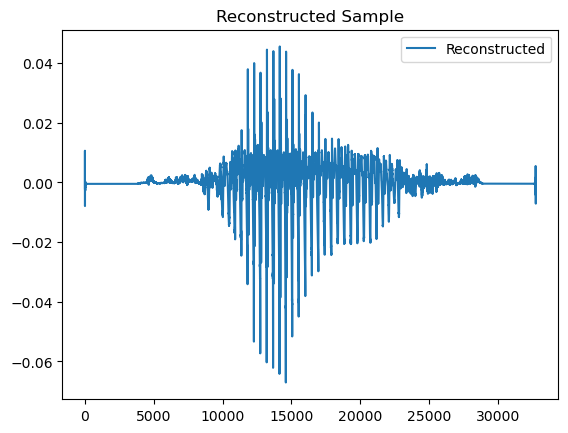

Test Error: 
 Avg loss: 0.000004 
 Avg MSE: 0.000004 

Epoch 19:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000005  [    0/24000]
loss: 0.000002  [ 6400/24000]
loss: 0.000006  [12800/24000]
loss: 0.000003  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

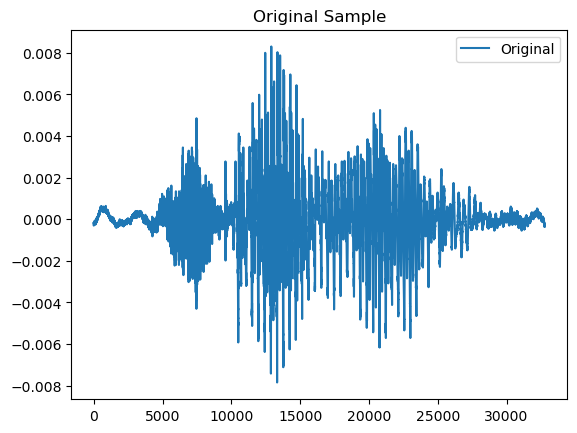

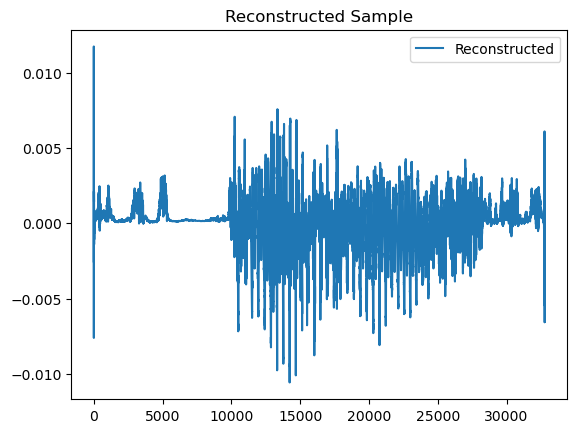

Test Error: 
 Avg loss: 0.000004 
 Avg MSE: 0.000004 

Epoch 20:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000019  [    0/24000]
loss: 0.000007  [ 6400/24000]
loss: 0.000005  [12800/24000]
loss: 0.000004  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

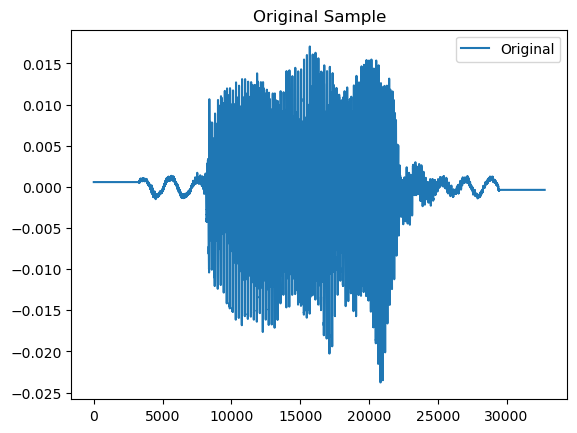

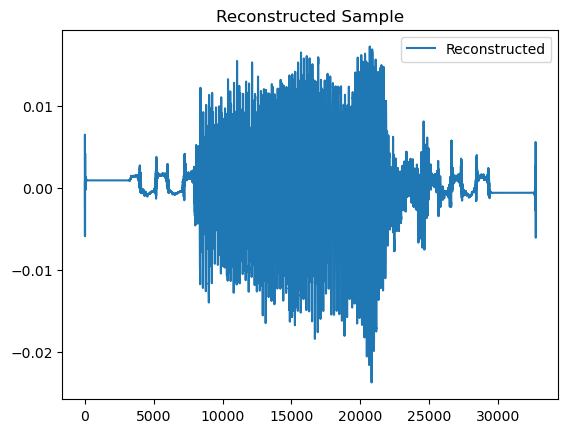

Test Error: 
 Avg loss: 0.000004 
 Avg MSE: 0.000004 

Epoch 21:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000012  [    0/24000]
loss: 0.000002  [ 6400/24000]
loss: 0.000004  [12800/24000]
loss: 0.000006  [19200/24000]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

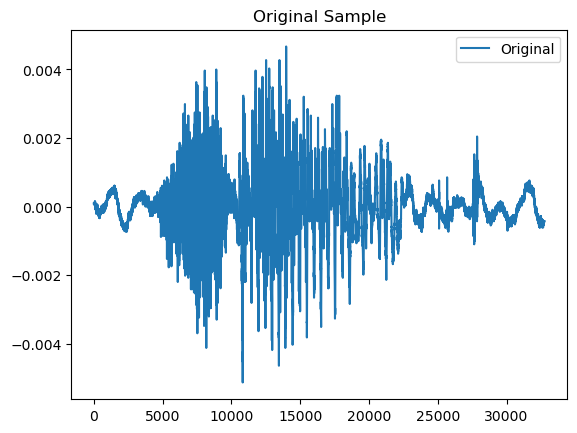

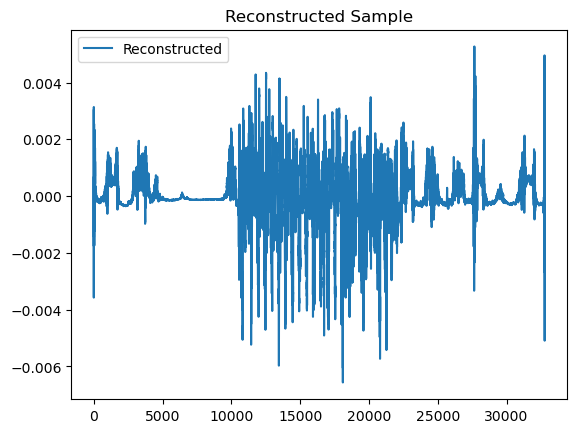

In [ ]:
def del_if_found(variable):
    try:
        del variable
    except:
        pass

# initialize pandas dataframe
df = pd.DataFrame(columns=['conv_layers', 'time_took', 'test_mse'])

# maximum number of iterations without improvement
MAX_ITERATIONS_WITHOUT_IMPROVEMENT = 5

for conv_layers in range(4, 10):
    model = AutoEncoder(convolutional_layers=conv_layers).to(device)
    loss_fn = nn.MSELoss()
    #optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print(f"Training with {conv_layers} convolutional layers")

    # start training
    start_time = time.time()
    current_mse = 1
    epoch = 0
    iterations_without_improvement = 0
    best_mse = float('inf')
    
    while iterations_without_improvement < MAX_ITERATIONS_WITHOUT_IMPROVEMENT:
        print(f"Epoch {epoch}:")
        train(dataloader_train, model, loss_fn, optimizer)
        loss, mse = test(dataloader_test, model, loss_fn, f"{conv_layers}_{epoch}")
        current_mse = mse
        
        if current_mse < best_mse:
            best_mse = current_mse
            iterations_without_improvement = 0
        else:
            iterations_without_improvement += 1

        epoch += 1

    time_took = time.time() - start_time
    print(f"Training time: {time_took} seconds")
    print(f"Epochs: {epoch}")

    # save the model
    torch.save(model.state_dict(), f"model_{conv_layers}.pth")
    print("Saved PyTorch Model State to model.pth")

    # save the results
    df.loc[len(df)] = [conv_layers, time_took, best_mse.cpu().item()]

    # save the results
    df.to_csv('results.csv', index=False)

    print("Done!")

    # del variables on gpu and skip if one of them is not found
    del_if_found(model)
    del_if_found(sample)
    del_if_found(label)
    print(df)